# EcoSorter

## Import Library

In [ ]:
# Import library yang diperlukan
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Preprocessing

In [ ]:
base_dir = '/content/drive/MyDrive/Garbage Classification/dataset'

In [ ]:
classes = os.listdir(base_dir)
print(classes)

['kaca', 'kardus', 'kertas', 'logam', 'organik', 'plastik', 'khusus']


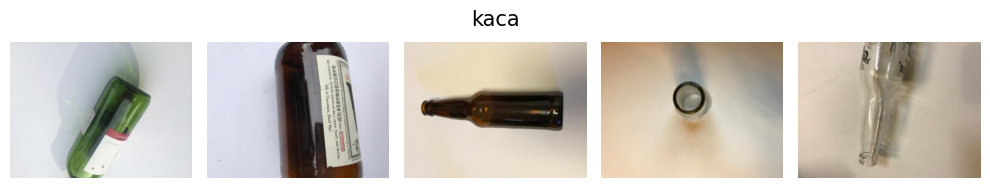

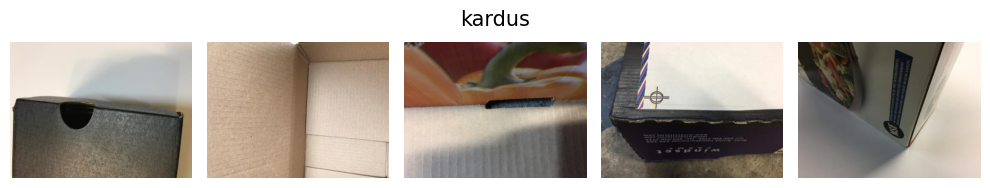

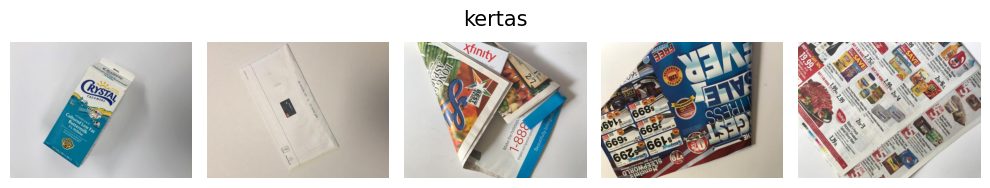

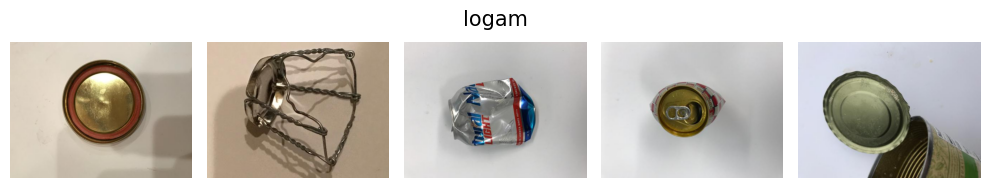

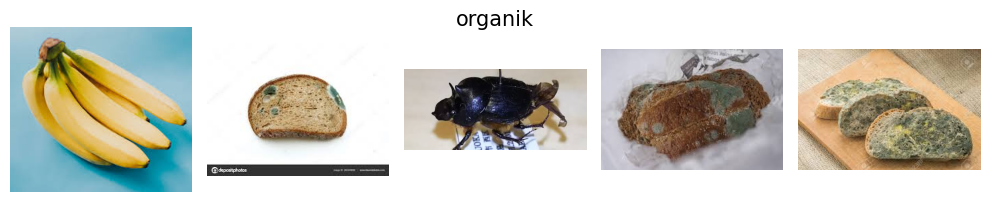

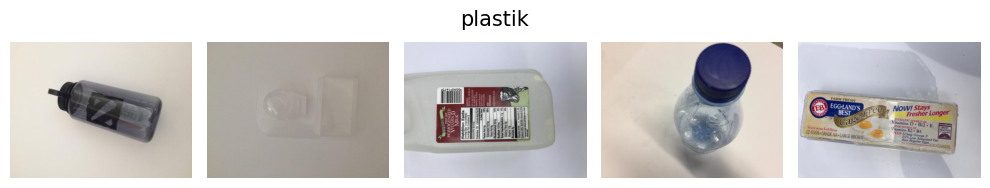

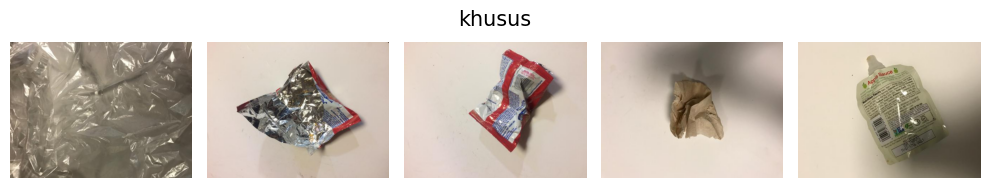

In [ ]:
# Iterate over each trash type (folder) to display images

for class_ in classes:
    folder_path = os.path.join(base_dir, class_)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:5]

        # Set up subplots
        fig, axs = plt.subplots(1, 5, figsize=(10, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(class_, fontsize=15, y=1.0)
        plt.show()

In [ ]:
# Convert to DataFrame
data = []
for class_ in classes:
    for file in os.listdir(os.path.join(base_dir, class_)):
        data.append((os.path.join(base_dir, class_, file), class_))

df = pd.DataFrame(data, columns=['File', 'Label'])
df.head()

,File,Label
0,/content/drive/MyDrive/Garbage Classification/...,kaca
1,/content/drive/MyDrive/Garbage Classification/...,kaca
2,/content/drive/MyDrive/Garbage Classification/...,kaca
3,/content/drive/MyDrive/Garbage Classification/...,kaca
4,/content/drive/MyDrive/Garbage Classification/...,kaca


In [ ]:
df.shape

(3042, 2)

In [ ]:
df['Label'].value_counts()

Label
kertas     594
organik    515
kaca       501
plastik    482
logam      410
kardus     403
khusus     137
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   File    3042 non-null   object
 1   Label   3042 non-null   object
dtypes: object(2)
memory usage: 47.7+ KB


In [ ]:
df.duplicated().sum()

0

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'kaca'),
  Text(1, 0, 'kardus'),
  Text(2, 0, 'kertas'),
  Text(3, 0, 'logam'),
  Text(4, 0, 'organik'),
  Text(5, 0, 'plastik'),
  Text(6, 0, 'khusus')])

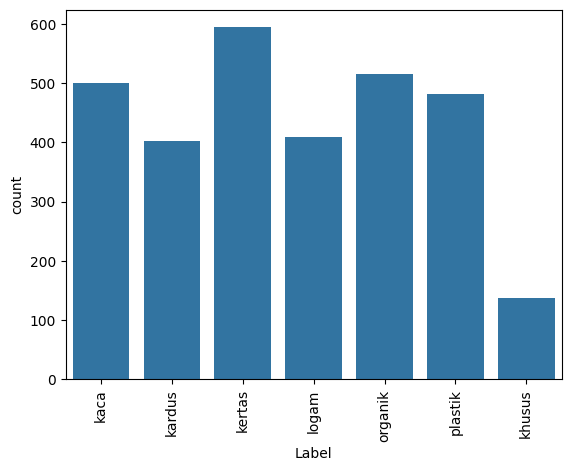

In [ ]:
sns.countplot(x = df['Label'])
plt.xticks(rotation='vertical')

## Build the Model with RestNet50

In [ ]:
BATCH_SIZE = 64
n_classes = 7

# Resnet50 base model
conv_base = ResNet50(input_shape= (224,224,3), weights='imagenet', include_top=False)

# Freeze all layers except the last two
for layer in conv_base.layers:
    layer.trainable = False

# Top model
top_model = tf.keras.layers.Flatten()(conv_base.output)
output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = tf.keras.Model(inputs=conv_base.input, outputs=output_layer)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Split the data into train and test/validation sets
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the test/validation set into test and validation sets
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Print the sizes of each dataset
print("Training dataset\t:", len(train_df))
print("Test dataset\t\t:", len(test_df))
print("Validation dataset\t:", len(val_df))


Training dataset	: 2433
Test dataset		: 304
Validation dataset	: 305


#### Image Preprocessing

In [ ]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
gen_val = ImageDataGenerator(preprocessing_function=preprocess_input)
gen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 32

train_generator = gen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="File",
    y_col="Label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
    shuffle=True
)

# Generate validation batches from the validation dataframe
val_generator = gen_val.flow_from_dataframe(
    dataframe=val_df,
    x_col="File",
    y_col="Label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Generate validation batches from the validation dataframe
test_generator = gen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="File",
    y_col="Label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2433 validated image filenames belonging to 7 classes.
Found 305 validated image filenames belonging to 7 classes.
Found 304 validated image filenames belonging to 7 classes.


#### Image Augmentation

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1, restore_best_weights=True)

In [ ]:
num_epochs = 50
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    filepath='model.h5',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = val_generator.samples // BATCH_SIZE
n_steps, n_val_steps

(76, 9)

### Model Training

In [ ]:
history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=n_steps,
    validation_data=val_generator,
    validation_steps=n_val_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.7514
Epoch 1: val_loss improved from inf to 0.62858, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 [==============================] - 585s 8s/step - loss: 1.0054 - accuracy: 0.7514 - val_loss: 0.6286 - val_accuracy: 0.8264 - lr: 1.0000e-04
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9683
Epoch 2: val_loss improved from 0.62858 to 0.61976, saving model to model.h5
76/76 [==============================] - 569s 8s/step - loss: 0.1044 - accuracy: 0.9683 - val_loss: 0.6198 - val_accuracy: 0.8576 - lr: 1.0000e-04
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9938
Epoch 3: val_loss improved from 0.61976 to 0.49906, saving model to model.h5
76/76 [==============================] - 546s 7s/step - loss: 0.0271 - accuracy: 0.9938 - val_loss: 0.4991 - val_accuracy: 0.8646 - lr: 1.0000e-04
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9983
Epoch 4: val_loss did not improve from 0.49906
76/76 [==============================] - 546s 7s/step - loss: 0.0195 - accur

## Evaluation and Visualization

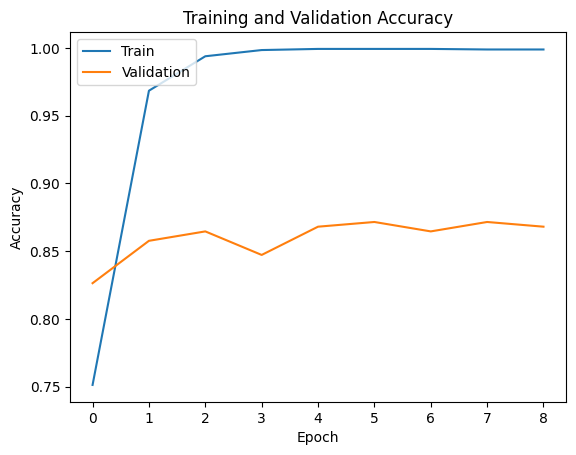

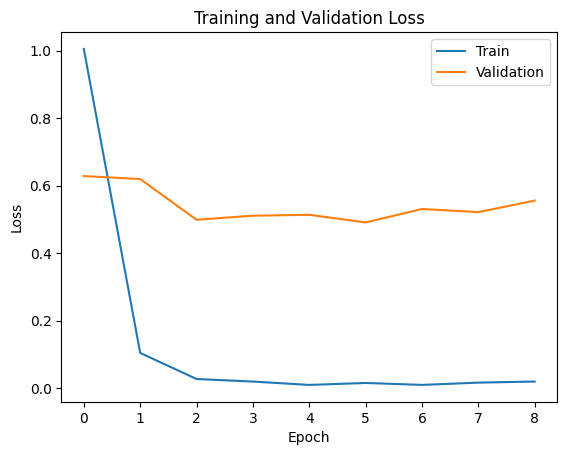

In [25]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [31]:
# Evaluasi model menggunakan val dataset
val_loss, val_accuracy = model.evaluate(val_generator)

# Print hasil evaluasi
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

10/10 [==============================] - 67s 6s/step - loss: 0.4994 - accuracy: 0.8754
Val Loss: 0.4993671476840973
Val Accuracy: 0.8754098415374756


## Prediction

In [32]:
output_class =  ['kaca', 'kardus', 'kertas', 'khusus', 'logam', 'organik', 'plastik']

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

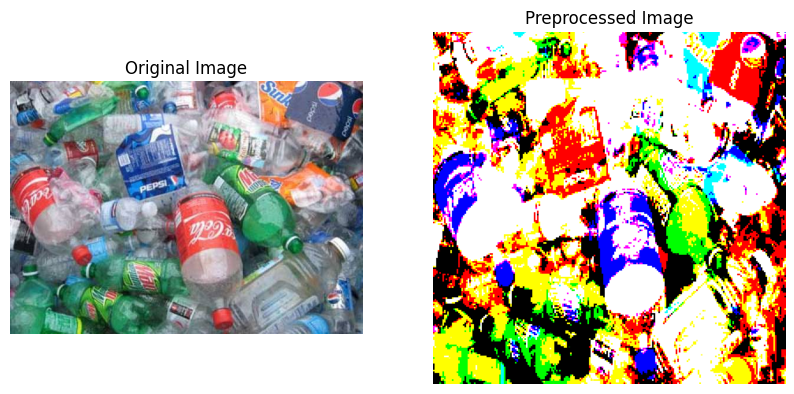

1/1 [==============================] - 0s 371ms/step
Your waste material is plastik with 98.56 % accuracy.


In [35]:
predict_user('/content/plastik.jpg')

## Save the Model

In [37]:
model.save('model.h5')